In [ ]:
# tensorflow-gpu

In [1]:
import tensorflow as tf
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
from sklearn.metrics import classification_report, confusion_matrix
import random
import matplotlib.pyplot as plt
import glob
import numpy as np
import cv2
import os
from collections import namedtuple
%matplotlib inline

C:\Users\User\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### 클래스(label) 확인

In [15]:
LABELS = []
for folder in glob.glob('./data/*') :
    label = folder.split('/')[-1]
    label = label.split('\\')[-1]
    # print(label)
    LABELS.append(label)
print(LABELS)

['30', '50', '60', '70', 'no_parking', 'no_parking_stop']


In [18]:
# 클래스 개수
N_CLASSES = len(LABELS)
print(N_CLASSES)
# input image size
RESIZED_IMAGE = (28, 28)

6


In [23]:
# 클래스별 이미지 개수(개수만)
img_cnt = []
for label in LABELS :
    # print('./data/{}/*.jpg'.format(label))
    cnt = 0
    for file in glob.glob('./data/{}/*.jpg'.format(label)) :
        cnt += 1
    img_cnt.append(cnt)
print(img_cnt)

[730, 750, 480, 660, 201, 331]


In [24]:
# 클래스별 이미지 개수
labels_cnt = {}
for label in LABELS :
    cnt = 0
    for file in glob.glob('./data/{}/*.jpg'.format(label)) :
        cnt += 1
    labels_cnt[label] = cnt
print(labels_cnt)

{'30': 730, '50': 750, '60': 480, '70': 660, 'no_parking': 201, 'no_parking_stop': 331}


In [26]:
LABEL_IDX = {}
for label, i in zip(LABELS, range(0, N_CLASSES)) :
    LABEL_IDX[label] = i
print(LABEL_IDX)

{'30': 0, '50': 1, '60': 2, '70': 3, 'no_parking': 4, 'no_parking_stop': 5}


In [28]:
IDX_LABEL = {}
for i, label in zip(range(0, N_CLASSES), LABELS) :
    IDX_LABEL[i] = label
print(IDX_LABEL)

{0: '30', 1: '50', 2: '60', 3: '70', 4: 'no_parking', 5: 'no_parking_stop'}


### 데이터셋 만들기

In [29]:
Dataset = namedtuple('Dataset', ['X', 'y'])
print(Dataset)

<class '__main__.Dataset'>


In [30]:
# 텐서플로우에 맞는 이미지 텐서 포맷 : [?, ?, ?, ?]
# 차원 확장
def to_tf_format(imgs) :
    return np.stack([img[:, :, np.newaxis] for img in imgs], axis = 0).astype(np.float32)

In [34]:
# 한 경로에 주어진 모든 이미지를 읽어서
# 그 이미지를 미리 정의한 형상으로 크기 재조정
# 회색조로 변환
# 레이블 원-핫 인코딩

def read_dataset(root_path, labels_arr, resize_to) :
    images = []
    labels = []
    
    for label_name in labels_arr :
        # 'data/no_parking/'
        full_path = root_path + '/' + label_name + '/'
        
        for img in glob.glob(full_path + '*.jpg') :
            image = cv2.imread(img).astype(np.float32)
            # 회색조로 변환
            image = cv2.cvtColor(image, cv2.IMREAD_GRAYSCALE)[:, :, 0]
            # 크기 조정
            if resize_to : 
                image = cv2.resize(image, resize_to)
            
            # 라벨
            # 원-핫 인코딩
            label = np.zeros((N_CLASSES, ), dtype = np.float32)
            label[LABEL_IDX[label_name]] = 1.0
            
            images.append(image.astype(np.float32))
            labels.append(label)
            
    return Dataset(X = to_tf_format(images).astype(np.float32), y = np.matrix(labels).astype(np.float32))

In [35]:
dataset = read_dataset('data', LABELS, RESIZED_IMAGE)
print(dataset.X.shape)
print(dataset.y.shape)

(3152, 28, 28, 1)
(3152, 6)


In [36]:
print(dataset.X.shape, dataset.X[0, :, :, :].shape)

(3152, 28, 28, 1) (28, 28, 1)


In [37]:
print((dataset.X[0, :, :, :].reshape(RESIZED_IMAGE)).shape)

(28, 28)


[[1. 0. 0. 0. 0. 0.]]


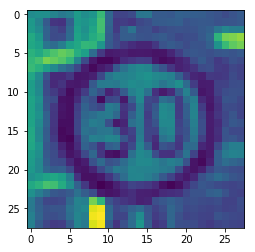

In [38]:
# 첫번째 표본
plt.imshow(dataset.X[0, :, :, :].reshape(RESIZED_IMAGE))
# 레이블
print(dataset.y[0, :])

[[0. 0. 0. 0. 0. 1.]]


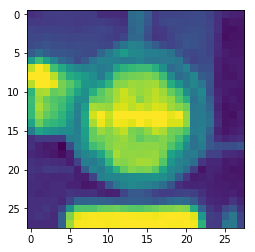

In [39]:
# 마지막 표본
plt.imshow(dataset.X[-1, :, :, :].reshape(RESIZED_IMAGE))
# 레이블
print(dataset.y[-1, :])

In [40]:
# train/test 데이터셋 분류
from sklearn.model_selection import train_test_split

idx_train, idx_test = train_test_split(range(dataset.X.shape[0]), test_size = 0.25, random_state = 101 )

In [42]:
# idx_train

In [44]:
# idx_test

In [45]:
len(idx_train), len(idx_test)

(2364, 788)

In [46]:
X_train = dataset.X[idx_train, :, :, :]
X_test = dataset.X[idx_test, :, :, :]
y_train = dataset.y[idx_train, :]
y_test = dataset.y[idx_test, :]

In [52]:
# y_train, len(y_train)

In [50]:
# y_test, len(y_test)

In [53]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(2364, 28, 28, 1)
(788, 28, 28, 1)
(2364, 6)
(788, 6)


In [54]:
# 훈련 데이터의 미니배치 생성

def minibatcher(X, y, batch_size, shuffle) :
    assert X.shape[0] == y.shape[0]
    n_samples = X.shape[0]
    
    if shuffle :
        idx = np.random.permutation(n_samples)
    else :
        idx = list(range(n_samples))
        
    for k in range(int(np.ceil(n_samples / batch_size))) :
        from_idx = k * batch_size
        to_idx = (k+1) * batch_size
        yield X[idx[from_idx:to_idx], :, :, :], y[idx[from_idx:to_idx], :]

In [55]:
for mb in minibatcher(X_train, y_train, 1000, True) :
    print(mb[0].shape, mb[1].shape)

(1000, 28, 28, 1) (1000, 6)
(1000, 28, 28, 1) (1000, 6)
(364, 28, 28, 1) (364, 6)


### 모델 구성

In [ ]:
# optimizer : AdamOptimizer

In [57]:
# hyperparameters
learning_rate = 0.001
training_epochs = 15
batch_size = 100

In [177]:
# 모델 클래스 생성

class Model :
    
    def __init__(self, sess, name) :
        self.sess = sess
        self.name = name
        self._build_net()
        
    def _build_net(self) :
        with tf.variable_scope(self.name) :

            # dropout rate
            # 0.7 ~ 0.5 on training, but should be 1 for testing
            # self.keep_prob = tf.placeholder(tf.float32)
            self.training = tf.placeholder(tf.bool)

            # input placeholders
            self.X = tf.placeholder(tf.float32, shape = (None, RESIZED_IMAGE[0], RESIZED_IMAGE[1], 1), name='input')
            self.y = tf.placeholder(tf.float32, shape = (None, N_CLASSES))

            # Layer1
            conv1 = tf.layers.conv2d(inputs = self.X, filters = 32, kernel_size = [3, 3], padding = 'SAME', activation = tf.nn.relu)
            pool1 = tf.layers.max_pooling2d(inputs = conv1, pool_size = [2, 2], padding = 'SAME', strides = 2)
            dropout1 = tf.layers.dropout(inputs = pool1, rate = 0.3, training = self.training)

            # Layer2
            conv2 = tf.layers.conv2d(inputs = dropout1, filters = 64, kernel_size = [3, 3], padding = 'SAME', activation = tf.nn.relu)
            pool2 = tf.layers.max_pooling2d(inputs = conv2, pool_size = [2, 2], padding = 'SAME', strides = 2)
            dropout2 = tf.layers.dropout(inputs = pool2, rate = 0.3, training = self.training)

            # Layer3
            conv3 = tf.layers.conv2d(inputs = dropout2, filters = 128, kernel_size = [3, 3], padding = 'SAME', activation = tf.nn.relu)
            pool3 = tf.layers.max_pooling2d(inputs = conv3, pool_size = [2, 2], padding = 'SAME', strides = 2)
            dropout3 = tf.layers.dropout(inputs = pool3, rate = 0.3, training = self.training)

            # Dense Layer with Relu
            flat = tf.reshape(dropout3, [-1, 128 * 4 * 4])
            dense4 = tf.layers.dense(inputs = flat, units = 625, activation = tf.nn.relu)
            dropout4 = tf.layers.dropout(inputs = dense4, rate = 0.5, training = self.training)

            # Logits (no activation) Layer
            self.logits = tf.layers.dense(inputs = dropout4, units = N_CLASSES, name='op_to_restore')
            # self.sm_logits = tf.nn.softmax(self.logits)

            # define cost/loss & optimizer
            self.cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = self.logits, labels = self.y))
            self.optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(self.cost)

            correct_prediction = tf.equal(tf.argmax(self.logits, 1), tf.argmax(self.y, 1))
            self.accuracy = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
            
    def train(self, X_data, y_data, training = True) :
        return self.sess.run([self.cost, self.optimizer], feed_dict = {self.X : X_data, self.y : y_data, self.training : training})
            
    def predict(self, X_test, training = False) :
        return self.sess.run(self.logits, feed_dict = {self.X : X_test, self.training : training})
        
    def get_accuracy(self, X_test, y_test, training = False) :
        return self.sess.run(self.accuracy, feed_dict = {self.X : X_test, self.y : y_test, self.training : training})

In [182]:
tf.reset_default_graph()

### 모델 학습 및 저장

In [180]:
CHECK_POINT_DIR = './model.ckpt'
if not os.path.exists(CHECK_POINT_DIR) :
    os.makedirs(CHECK_POINT_DIR)

In [183]:
# initialize
config = ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
m1 = Model(sess, "m1")
sess.run(tf.global_variables_initializer())

In [184]:
# save model
saver = tf.train.Saver()

In [185]:
# train
for epoch in range(training_epochs) :
    print("Epoch = ", epoch)
    cost = []
    # total_batch = int(len(idx_train) / batch_size)
    
    for mb in minibatcher(X_train, y_train, batch_size, True) :
        c, _ = m1.train(mb[0], mb[1])
        # avg_cost += c / total_batch
        cost.append(c)
    # print('Epoch : ', '%04d' % (epoch + 1), 'cost = ', '{:.9f}'.format(avg_cost))
    print('cost = ', np.mean(cost))

Epoch =  0
cost =  12.277232
Epoch =  1
cost =  1.7412008
Epoch =  2
cost =  1.6970943
Epoch =  3
cost =  1.6558262
Epoch =  4
cost =  1.6216532
Epoch =  5
cost =  1.5823272
Epoch =  6
cost =  1.5541004
Epoch =  7
cost =  1.5310688
Epoch =  8
cost =  1.478363
Epoch =  9
cost =  1.4347075
Epoch =  10
cost =  1.4389132
Epoch =  11
cost =  1.3774357
Epoch =  12
cost =  1.3421623
Epoch =  13
cost =  1.3256332
Epoch =  14
cost =  1.304011


In [186]:
saver.save(sess, CHECK_POINT_DIR + '/model')
print('Trained Model Saved.')

Trained Model Saved.


In [187]:
graph = tf.get_default_graph()

In [189]:
op_to_restore = graph.get_tensor_by_name("op_to_restore")
# print (sess.run(op_to_restore, feed_dict = {}))

ValueError: The name 'op_to_restore' looks like an (invalid) Operation name, not a Tensor. Tensor names must be of the form "<op_name>:<output_index>".

In [65]:
checkpoint = tf.train.get_checkpoint_state(CHECK_POINT_DIR)
print(checkpoint)
print(checkpoint.model_checkpoint_path)

model_checkpoint_path: "./model.ckpt\\model"
all_model_checkpoint_paths: "./model.ckpt\\model"

./model.ckpt\model


### 예측

In [67]:
print(m1.predict(X_test))
print(len(m1.predict(X_test)))

[[ 0.8394135   0.57725984  0.77131873  0.48589075 -1.1965182  -0.7298148 ]
 [ 1.4866767   0.864991    1.2463247   0.34972167 -1.0635111  -0.6978194 ]
 [-0.52527356 -0.58752    -0.805132   -0.4591061   0.8679822   1.6373388 ]
 ...
 [ 0.0735733  -0.21622755  0.19806844 -0.34529835 -0.19053043  0.2260623 ]
 [ 0.824553    0.58386284  0.60473406  0.4750604  -0.6730729  -0.5817538 ]
 [ 1.3425385   1.3766915   0.775731    1.4301983  -1.1093047  -1.3831418 ]]
788


In [68]:
sess.run(tf.argmax(m1.predict(X_test), 1))

array([0, 0, 5, 2, 3, 5, 0, 1, 5, 3, 0, 2, 3, 3, 4, 3, 3, 4, 0, 4, 2, 3,
       3, 4, 1, 1, 3, 1, 0, 3, 5, 5, 3, 3, 4, 4, 1, 3, 1, 3, 3, 3, 2, 3,
       4, 2, 3, 3, 3, 1, 0, 3, 5, 5, 2, 4, 1, 3, 4, 0, 2, 0, 0, 2, 2, 1,
       3, 5, 0, 0, 3, 3, 3, 2, 2, 3, 3, 1, 5, 1, 3, 3, 2, 4, 0, 3, 2, 3,
       3, 5, 3, 3, 3, 3, 0, 5, 1, 1, 4, 0, 2, 0, 4, 5, 3, 0, 3, 0, 5, 3,
       5, 1, 2, 5, 3, 4, 5, 3, 5, 3, 3, 0, 1, 2, 0, 1, 0, 3, 1, 0, 2, 3,
       3, 2, 3, 0, 3, 1, 5, 3, 5, 4, 3, 1, 3, 3, 3, 3, 5, 3, 3, 1, 0, 3,
       5, 1, 1, 0, 1, 4, 3, 0, 5, 1, 1, 5, 4, 3, 4, 0, 0, 2, 3, 3, 3, 1,
       2, 5, 3, 0, 1, 1, 5, 0, 3, 3, 3, 0, 3, 0, 0, 2, 1, 5, 3, 2, 2, 3,
       3, 1, 2, 0, 2, 0, 3, 2, 3, 3, 3, 2, 3, 3, 0, 3, 5, 3, 2, 3, 0, 3,
       3, 5, 3, 3, 3, 4, 3, 5, 5, 2, 5, 3, 4, 3, 3, 3, 5, 2, 3, 5, 3, 0,
       0, 1, 5, 3, 3, 3, 0, 3, 3, 0, 4, 0, 5, 3, 2, 5, 3, 0, 3, 5, 0, 2,
       0, 3, 0, 1, 0, 0, 3, 0, 1, 3, 1, 5, 1, 3, 1, 3, 3, 0, 2, 4, 1, 3,
       5, 3, 3, 5, 0, 2, 3, 0, 4, 5, 3, 1, 1, 2, 3,

In [70]:
# list(sess.run(tf.argmax(m1.predict(X_test), 1)))

In [72]:
pred_num = list(sess.run(tf.argmax(m1.predict(X_test), 1)))
pred_name = []
for num in pred_num :
    pred_name.append(IDX_LABEL[num])
# print(pred_name)

In [74]:
sess.run(tf.argmax(y_test, 1))

array([2, 0, 5, 0, 3, 1, 0, 1, 1, 3, 0, 0, 3, 3, 0, 2, 2, 2, 0, 1, 1, 3,
       3, 3, 1, 0, 3, 1, 0, 3, 1, 5, 3, 3, 4, 4, 1, 3, 0, 1, 3, 0, 0, 1,
       4, 3, 0, 1, 0, 1, 0, 1, 4, 4, 1, 3, 1, 0, 4, 5, 2, 0, 0, 1, 3, 0,
       1, 5, 1, 1, 3, 1, 3, 3, 4, 2, 0, 1, 5, 0, 1, 3, 2, 4, 1, 3, 2, 3,
       3, 5, 1, 3, 1, 3, 1, 5, 0, 1, 5, 1, 0, 0, 0, 4, 3, 3, 1, 0, 5, 0,
       5, 1, 2, 4, 3, 3, 5, 3, 5, 2, 1, 3, 0, 1, 1, 5, 0, 1, 3, 0, 1, 2,
       3, 2, 2, 0, 2, 0, 5, 3, 1, 4, 3, 5, 2, 3, 3, 3, 5, 2, 2, 3, 1, 0,
       5, 0, 1, 0, 3, 1, 1, 4, 5, 1, 0, 5, 4, 2, 4, 0, 0, 2, 3, 1, 1, 1,
       0, 5, 1, 1, 2, 1, 4, 1, 0, 3, 2, 0, 3, 0, 5, 1, 1, 5, 1, 1, 2, 2,
       2, 0, 2, 1, 0, 0, 2, 2, 3, 3, 2, 0, 3, 2, 0, 1, 5, 0, 2, 3, 2, 3,
       1, 0, 0, 2, 3, 4, 3, 5, 5, 2, 4, 3, 5, 0, 3, 3, 3, 1, 3, 5, 2, 1,
       0, 1, 0, 0, 1, 2, 1, 0, 1, 0, 2, 3, 5, 3, 2, 5, 3, 0, 3, 0, 0, 0,
       5, 3, 0, 3, 0, 3, 2, 2, 5, 2, 2, 5, 1, 2, 1, 2, 3, 1, 3, 4, 1, 2,
       5, 0, 0, 5, 0, 2, 3, 0, 4, 5, 2, 4, 5, 5, 1,

In [73]:
# Test model and check accuracy
print('accuracy = ', m1.get_accuracy(X_test, y_test))

accuracy =  0.4606599


### 시각화

In [75]:
# classification_report
print(classification_report(sess.run(tf.argmax(y_test, 1)), sess.run(tf.argmax(m1.predict(X_test), 1))))

             precision    recall  f1-score   support

          0       0.54      0.42      0.47       191
          1       0.39      0.23      0.29       190
          2       0.37      0.29      0.32       119
          3       0.39      0.69      0.50       153
          4       0.48      0.64      0.55        44
          5       0.69      0.78      0.73        91

avg / total       0.46      0.46      0.44       788



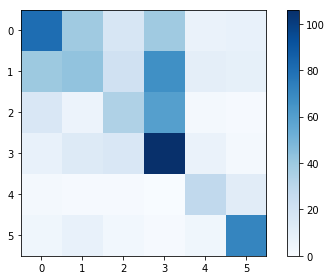

In [76]:
# confusion_matrix(혼동행렬)
cm = confusion_matrix(sess.run(tf.argmax(y_test, 1)), sess.run(tf.argmax(m1.predict(X_test), 1)))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.colorbar()
plt.tight_layout()
plt.show()

In [119]:
# 세션 종료
sess.close()

In [156]:
tf.reset_default_graph()

### 실시간 영상에 분류 결과 나타내기

In [157]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
import tensorflow as tf
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

In [158]:
CHECK_POINT_DIR = './model.ckpt'

In [159]:
checkpoint = tf.train.get_checkpoint_state(CHECK_POINT_DIR)

In [160]:
print(checkpoint)
print(checkpoint.model_checkpoint_path)

model_checkpoint_path: "./model.ckpt\\model"
all_model_checkpoint_paths: "./model.ckpt\\model"

./model.ckpt\model


In [126]:
# config = ConfigProto()
# config.gpu_options.allow_growth = True
# sess = tf.Session(config=config)
# sess.run(tf.global_variables_initializer())

In [128]:
# # load a trained model
# if checkpoint and checkpoint.model_checkpoint_path :
#     try : 
#         saver = tf.train.import_meta_graph(checkpoint.model_checkpoint_path + '.meta')
#         saver.restore(sess, checkpoint.model_checkpoint_path)
#         print('Successfully loaded : ', checkpoint.model_checkpoint_path)
#     except :
#         print("Error on loading old network weights")
# else :
#     print("Could not find old network weights")

In [170]:
# load a trained model
if checkpoint and checkpoint.model_checkpoint_path :
    try : 
        saver = tf.train.import_meta_graph(checkpoint.model_checkpoint_path + '.meta')
        config = ConfigProto()
        config.gpu_options.allow_growth = True
        sess = tf.Session(config=config)
        sess.run(tf.global_variables_initializer())
        saver.restore(sess, checkpoint.model_checkpoint_path)
        print('Successfully loaded : ', checkpoint.model_checkpoint_path)
    except :
        print("Error on loading old network weights")
else :
    print("Could not find old network weights")

INFO:tensorflow:Restoring parameters from ./model.ckpt\model
Successfully loaded :  ./model.ckpt\model


In [172]:
m2 = Model(sess, "m2")

In [173]:
print('accuracy = ', m2.get_accuracy(X_test, y_test))

FailedPreconditionError: Attempting to use uninitialized value m2/dense_1/bias
	 [[node m2/dense_1/bias/read (defined at <ipython-input-58-ad51d7a85b4c>:43) ]]

Caused by op 'm2/dense_1/bias/read', defined at:
  File "C:\Users\User\Anaconda3\lib\runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "C:\Users\User\Anaconda3\lib\runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "C:\Users\User\Anaconda3\lib\site-packages\ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "C:\Users\User\Anaconda3\lib\site-packages\traitlets\config\application.py", line 658, in launch_instance
    app.start()
  File "C:\Users\User\Anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 486, in start
    self.io_loop.start()
  File "C:\Users\User\Anaconda3\lib\site-packages\tornado\platform\asyncio.py", line 127, in start
    self.asyncio_loop.run_forever()
  File "C:\Users\User\Anaconda3\lib\asyncio\base_events.py", line 422, in run_forever
    self._run_once()
  File "C:\Users\User\Anaconda3\lib\asyncio\base_events.py", line 1432, in _run_once
    handle._run()
  File "C:\Users\User\Anaconda3\lib\asyncio\events.py", line 145, in _run
    self._callback(*self._args)
  File "C:\Users\User\Anaconda3\lib\site-packages\tornado\platform\asyncio.py", line 117, in _handle_events
    handler_func(fileobj, events)
  File "C:\Users\User\Anaconda3\lib\site-packages\tornado\stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\User\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 450, in _handle_events
    self._handle_recv()
  File "C:\Users\User\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 480, in _handle_recv
    self._run_callback(callback, msg)
  File "C:\Users\User\Anaconda3\lib\site-packages\zmq\eventloop\zmqstream.py", line 432, in _run_callback
    callback(*args, **kwargs)
  File "C:\Users\User\Anaconda3\lib\site-packages\tornado\stack_context.py", line 276, in null_wrapper
    return fn(*args, **kwargs)
  File "C:\Users\User\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 283, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "C:\Users\User\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 233, in dispatch_shell
    handler(stream, idents, msg)
  File "C:\Users\User\Anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 399, in execute_request
    user_expressions, allow_stdin)
  File "C:\Users\User\Anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 208, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "C:\Users\User\Anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 537, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "C:\Users\User\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2662, in run_cell
    raw_cell, store_history, silent, shell_futures)
  File "C:\Users\User\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2785, in _run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "C:\Users\User\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2903, in run_ast_nodes
    if self.run_code(code, result):
  File "C:\Users\User\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2963, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-172-ba14269a5e9e>", line 1, in <module>
    m2 = Model(sess, "m2")
  File "<ipython-input-58-ad51d7a85b4c>", line 8, in __init__
    self._build_net()
  File "<ipython-input-58-ad51d7a85b4c>", line 43, in _build_net
    self.logits = tf.layers.dense(inputs = dropout4, units = N_CLASSES)
  File "C:\Users\User\Anaconda3\lib\site-packages\tensorflow\python\util\deprecation.py", line 324, in new_func
    return func(*args, **kwargs)
  File "C:\Users\User\Anaconda3\lib\site-packages\tensorflow\python\layers\core.py", line 188, in dense
    return layer.apply(inputs)
  File "C:\Users\User\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\base_layer.py", line 1227, in apply
    return self.__call__(inputs, *args, **kwargs)
  File "C:\Users\User\Anaconda3\lib\site-packages\tensorflow\python\layers\base.py", line 530, in __call__
    outputs = super(Layer, self).__call__(inputs, *args, **kwargs)
  File "C:\Users\User\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\base_layer.py", line 538, in __call__
    self._maybe_build(inputs)
  File "C:\Users\User\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\base_layer.py", line 1603, in _maybe_build
    self.build(input_shapes)
  File "C:\Users\User\Anaconda3\lib\site-packages\tensorflow\python\keras\layers\core.py", line 958, in build
    trainable=True)
  File "C:\Users\User\Anaconda3\lib\site-packages\tensorflow\python\layers\base.py", line 435, in add_weight
    getter=vs.get_variable)
  File "C:\Users\User\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\base_layer.py", line 349, in add_weight
    aggregation=aggregation)
  File "C:\Users\User\Anaconda3\lib\site-packages\tensorflow\python\training\checkpointable\base.py", line 607, in _add_variable_with_custom_getter
    **kwargs_for_getter)
  File "C:\Users\User\Anaconda3\lib\site-packages\tensorflow\python\ops\variable_scope.py", line 1479, in get_variable
    aggregation=aggregation)
  File "C:\Users\User\Anaconda3\lib\site-packages\tensorflow\python\ops\variable_scope.py", line 1220, in get_variable
    aggregation=aggregation)
  File "C:\Users\User\Anaconda3\lib\site-packages\tensorflow\python\ops\variable_scope.py", line 547, in get_variable
    aggregation=aggregation)
  File "C:\Users\User\Anaconda3\lib\site-packages\tensorflow\python\ops\variable_scope.py", line 499, in _true_getter
    aggregation=aggregation)
  File "C:\Users\User\Anaconda3\lib\site-packages\tensorflow\python\ops\variable_scope.py", line 911, in _get_single_variable
    aggregation=aggregation)
  File "C:\Users\User\Anaconda3\lib\site-packages\tensorflow\python\ops\variables.py", line 213, in __call__
    return cls._variable_v1_call(*args, **kwargs)
  File "C:\Users\User\Anaconda3\lib\site-packages\tensorflow\python\ops\variables.py", line 176, in _variable_v1_call
    aggregation=aggregation)
  File "C:\Users\User\Anaconda3\lib\site-packages\tensorflow\python\ops\variables.py", line 155, in <lambda>
    previous_getter = lambda **kwargs: default_variable_creator(None, **kwargs)
  File "C:\Users\User\Anaconda3\lib\site-packages\tensorflow\python\ops\variable_scope.py", line 2495, in default_variable_creator
    expected_shape=expected_shape, import_scope=import_scope)
  File "C:\Users\User\Anaconda3\lib\site-packages\tensorflow\python\ops\variables.py", line 217, in __call__
    return super(VariableMetaclass, cls).__call__(*args, **kwargs)
  File "C:\Users\User\Anaconda3\lib\site-packages\tensorflow\python\ops\variables.py", line 1395, in __init__
    constraint=constraint)
  File "C:\Users\User\Anaconda3\lib\site-packages\tensorflow\python\ops\variables.py", line 1557, in _init_from_args
    self._snapshot = array_ops.identity(self._variable, name="read")
  File "C:\Users\User\Anaconda3\lib\site-packages\tensorflow\python\util\dispatch.py", line 180, in wrapper
    return target(*args, **kwargs)
  File "C:\Users\User\Anaconda3\lib\site-packages\tensorflow\python\ops\array_ops.py", line 81, in identity
    ret = gen_array_ops.identity(input, name=name)
  File "C:\Users\User\Anaconda3\lib\site-packages\tensorflow\python\ops\gen_array_ops.py", line 3889, in identity
    "Identity", input=input, name=name)
  File "C:\Users\User\Anaconda3\lib\site-packages\tensorflow\python\framework\op_def_library.py", line 788, in _apply_op_helper
    op_def=op_def)
  File "C:\Users\User\Anaconda3\lib\site-packages\tensorflow\python\util\deprecation.py", line 507, in new_func
    return func(*args, **kwargs)
  File "C:\Users\User\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 3300, in create_op
    op_def=op_def)
  File "C:\Users\User\Anaconda3\lib\site-packages\tensorflow\python\framework\ops.py", line 1801, in __init__
    self._traceback = tf_stack.extract_stack()

FailedPreconditionError (see above for traceback): Attempting to use uninitialized value m2/dense_1/bias
	 [[node m2/dense_1/bias/read (defined at <ipython-input-58-ad51d7a85b4c>:43) ]]
